In [13]:
!pip install bayesian-optimization

  Obtaining dependency information for bayesian-optimization from https://files.pythonhosted.org/packages/45/cf/3016b660afca02c6ecca3c1cc6d8df3b8f1a6ff4878103204d0aa6b4c769/bayesian_optimization-1.4.3-py3-none-any.whl.metadata



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
#import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from bayes_opt import BayesianOptimization
import numpy as np

In [3]:
df = pd.read_csv("bismillah.csv")

## One-Hot Encoder

In [4]:
from sklearn.preprocessing import OneHotEncoder

df = pd.concat([df, pd.get_dummies(df['kota'], prefix='kota')], axis=1)
df = pd.concat([df, pd.get_dummies(df['kecamatan'], prefix='kecamatan')], axis=1)
df.drop(['kota', 'kecamatan'], axis=1, inplace=True)
df.head()

,kamar_tidur,kamar_mandi,luas,harga,kota_Banjar,kota_Banjarbaru,kota_Banjarmasin,kota_Barito,kota_Kalimantan,kecamatan_Alalak,...,kecamatan_Banjarmasin Tengah,kecamatan_Banjarmasin Timur,kecamatan_Banjarmasin Utara,kecamatan_Gambut,kecamatan_Kertak Hanyar,kecamatan_Landasan Ulin,kecamatan_Liang Anggang,kecamatan_Martapura Kota,kecamatan_Sei/Sungai Tabuk,kecamatan_Tatah Makmur
0,2,2,70,400000000,False,False,True,False,False,False,...,False,True,False,False,False,False,False,False,False,False
1,2,1,60,400000000,False,False,True,False,False,False,...,False,True,False,False,False,False,False,False,False,False
2,2,1,120,550000000,False,False,True,False,False,False,...,False,False,True,False,False,False,False,False,False,False
3,3,2,100,555000000,False,False,True,False,False,False,...,False,False,True,False,False,False,False,False,False,False
4,2,1,45,400000000,False,False,True,False,False,False,...,False,True,False,False,False,False,False,False,False,False


## Split dataset

In [5]:
X = df.drop(columns=['harga'])
y = df['harga']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

## Standard Scaler

In [7]:
from sklearn.preprocessing import StandardScaler

numerical_features = ['kamar_mandi', 'kamar_tidur', 'luas']
scaler = StandardScaler()
scaler.fit(X_train[numerical_features])
X_train[numerical_features] = scaler.transform(X_train.loc[:, numerical_features])

## Bayesian Optimization

In [8]:
def grb_regression(n_estimators, max_depth, min_samples_split, min_samples_leaf):
    # param ubah ke int karena GBR tidak menerima float
    gbr = GradientBoostingRegressor(n_estimators=int(n_estimators),
                                    max_depth=int(max_depth),
                                    min_samples_split=int(min_samples_split),
                                    min_samples_leaf=int(min_samples_leaf),
                                    random_state=0)
    
    # evaluasi model menggunakan cross-validation
    scores = cross_val_score(gbr, X_train, y_train, 
                             scoring='neg_mean_squared_error', cv=5)
    return np.mean(scores)

In [9]:
param_bounds = {
    'n_estimators': (30, 60),
    'max_depth': (1, 32),
    'min_samples_split': (2, 10),
    'min_samples_leaf': (1, 10)
}

# Initialize the Bayesian Optimizer
GBR_BO = BayesianOptimization(
    f=grb_regression,
    pbounds=param_bounds,
    random_state=1
)

# Run the optimization
GBR_BO.maximize(
    n_iter=15,
    init_points=2
)

# Print the best parameters
print(GBR_BO.max)

|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 1         | -7.647e+1 | 13.93     | 7.483     | 2.001     | 39.07     |
| 2         | -8.014e+1 | 5.549     | 1.831     | 3.49      | 40.37     |
| 3         | -7.632e+1 | 13.22     | 6.895     | 2.353     | 39.91     |
| 4         | -7.484e+1 | 17.07     | 8.534     | 3.589     | 45.48     |
| 5         | -8.184e+1 | 21.81     | 5.927     | 10.0      | 46.29     |
| 6         | -7.643e+1 | 12.75     | 10.0      | 2.0       | 46.77     |
| 7         | -7.641e+1 | 19.86     | 10.0      | 2.0       | 42.09     |
| 8         | -8.383e+1 | 16.0      | 4.491     | 2.531     | 48.73     |
| 9         | -7.641e+1 | 15.26     | 10.0      | 4.052     | 42.88     |
| 10        | -7.72e+16 | 20.06     | 9.669     | 2.69      | 46.46     |
| 11        | -7.698e+1 | 17.61     | 6.382     | 3.259     | 41.96     |
| 12        | -7.716e+1 | 14.71     | 

## Model development

In [16]:
GBR_new = GradientBoostingRegressor(max_depth= 17, 
                                    min_samples_leaf=9, 
                                    min_samples_split=4,
                                    n_estimators=45)

model = GBR_new.fit(X_train, y_train)

In [17]:
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
print(f"MSE: {mse} and RMSE:{rmse}")

MSE: 3.13983342408982e+17 and RMSE:560342165.4747945


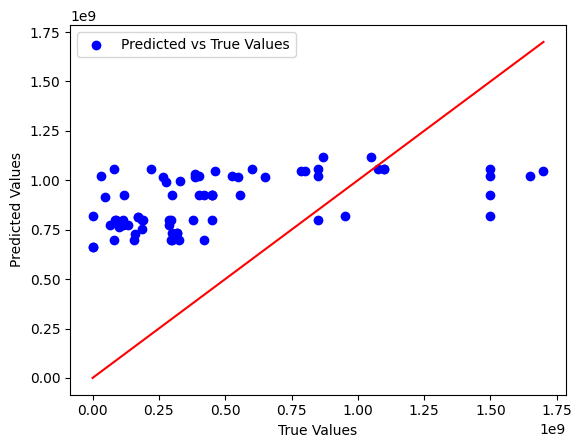

In [18]:
# Scatter plot of true vs predicted values
plt.scatter(y_test, y_pred, color='blue', label='Predicted vs True Values')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')  # Diagonal line for reference
plt.show()